# Plan-and-Execute

이 튜토리얼에서는 "plan-and-execute" 스타일의 에이전트를 만드는 방법을 소개하고, 이를 [LangGraph](https://langchain-ai.github.io/langgraph/)를 활용하여 구현하는 과정을 단계별로 설명합니다.  
"plan-and-execute" 전략은 복잡한 작업을 수행할 때 장기적인 계획을 먼저 수립한 뒤, 해당 계획을 단계별로 실행하며 필요에 따라 다시 계획을 재수정하는 접근법입니다.

![](./assets/langgraph-plan-and-execute.png)

---

## Plan-and-Execute란 무엇인가?

"plan-and-execute"는 다음과 같은 특징을 갖는 접근 방식입니다.

- **장기 계획 수립**: 복잡한 작업을 수행하기 전에 큰 그림을 그리는 장기 계획을 수립합니다.
- **단계별 실행 및 재계획**: 세운 계획을 단계별로 실행하고, 각 단계가 완료될 때마다 계획이 여전히 유효한지 검토한 뒤 수정할 수 있습니다.
  
이 방식은 [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)과 [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)에서 영감을 받았습니다. 전통적인 [ReAct 스타일](https://arxiv.org/abs/2210.03629)의 에이전트는 한 번에 한 단계씩 생각하는 반면, "plan-and-execute"는 명시적이고 장기적인 계획을 강조합니다.

**장점**:
1. **명시적인 장기 계획**: 강력한 LLM조차도 한 번에 장기 계획을 처리하는 데 어려움을 겪을 수 있습니다. 명시적으로 장기 계획을 수립함으로써, 보다 안정적인 진행이 가능합니다.
2. **효율적인 모델 사용**: 계획 단계에서는 더 큰/강력한 모델을 사용하고, 실행 단계에서는 상대적으로 작은/약한 모델을 사용함으로써 자원 소비를 최적화할 수 있습니다.

---

**주요 내용**

- **도구 정의**: 사용할 도구 정의
- **실행 에이전트 정의**: 실제 작업을 실행하는 에이전트 생성
- **상태 정의**: 에이전트의 상태 정의
- **계획 단계**: 장기 계획을 세우는 단계 생성
- **재계획 단계**: 작업 진행 상황에 따라 계획을 재수정하는 단계 생성
- **그래프 생성 및 실행**: 이러한 단계들을 연결하는 그래프 생성 및 실행

---

**참고**

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)  
- [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)  
- [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)  
- [ReAct 논문](https://arxiv.org/abs/2210.03629)

지금부터는 각 단계를 따라가며 "plan-and-execute" 에이전트를 LangGraph로 구현하는 방법을 자세히 알아보겠습니다.

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv(override=True)

True

In [2]:
# LangSmith 추적을 설정합니다.
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangGraph-Use-Cases


실습에 활용할 모델명 정의

In [3]:
from langchain_teddynote.models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


## 도구 정의

사용할 도구를 먼저 정의합니다. 이 간단한 예제에서는 `Tavily`를 통해 제공되는 내장 검색 도구를 사용할 것입니다. 그러나 직접 도구를 만드는 것도 매우 쉽습니다. 

자세한 내용은 [도구(Tools)](https://wikidocs.net/262582) 문서를 참조하십시오.

In [4]:
from langchain_teddynote.tools import TavilySearch

# Tavily 검색 도구 초기화
tools = [TavilySearch(max_results=8)]

## 작업 실행 에이전트 정의

이제 작업을 실행할 `execution agent`를 생성합니다. 

이 예제에서는 각 작업에 동일한 `execution agent`를 사용할 예정이지만, 반드시 이렇게 해야 하는 것은 아닙니다.

In [5]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# LLM 정의
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [6]:
# 에이전트 실행
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)

{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='f9c7c229-f3b8-4fe9-af3a-bf4fa4d00d1a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zqCTWM7xGon97Kn7EWtfszFM', 'function': {'arguments': '{"query":"랭체인 한국어 튜토리얼"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 159, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CRULtf1lvwN0FXDkCv4wmhyZ4cFBx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--525c1647-c111-4245-a17c-e0179cc1f538-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인 한국어 튜토

## 상태 정의

- `input`: 사용자의 입력
- `plan`: 현재 계획
- `past_steps`: 이전에 실행한 계획과 실행 결과
- `response`: 최종 응답

In [7]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

## 계획(Plan) 단계

이제 **계획 단계**를 생성하는 방법을 고려해 보겠습니다. 이 단계에서는 `function calling` 을 사용하여 계획을 수립합니다.

In [8]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Plan)

`planner` 를 실행하여 계획을 수립한 결과를 확인합니다.

In [10]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                """Slot Filling

사용자 질문의 의도를 정확하게 파악하고 답변을 하기 위해서는 꼭 필요한 정보들이 있을텐데, 해당 entity를 어떻게 확보해서 답변을 할 수 있을지 고민이 있습니다.
예를들면 회의실을 예약하는 시나리오라고 하면, 시간, 장소, 인원 등의 필수 정보가 있어야할텐데 이런 항목을 multi-turn 활용하여 채울 수 있는 방법이 있겠으나
범용적으로 사용하기에는 도메인별로 필요한 Entity가 달라서 어떻게 하면 좋을지 고민 입니다.
외부에서 Slot Filling 방식으로 활용하고 있는지, 어떻게 활용하는지 알고 싶습니다.  """,
            )
        ]
    }
)

Plan(steps=['사용자의 질문을 분석하여 필요한 엔티티를 식별한다.', '식별된 엔티티 중 누락된 정보를 확인한다.', '누락된 정보를 사용자에게 추가로 질문하여 수집한다.', '수집된 모든 정보를 바탕으로 사용자의 질문에 대한 답변을 생성한다.'])

## 재계획(Re-Plan) 단계

이제 이전 단계의 결과를 바탕으로 계획을 다시 수립하는 단계를 생성합니다.

In [11]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)

## 그래프 생성

이제 그래프를 생성할 수 있습니다.

In [12]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = (
    final_report_prompt
    | ChatOpenAI(model=MODEL_NAME, temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

## 그래프 생성

이제 지금까지 정의한 노드를 연결하여 그래프를 생성합니다.

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

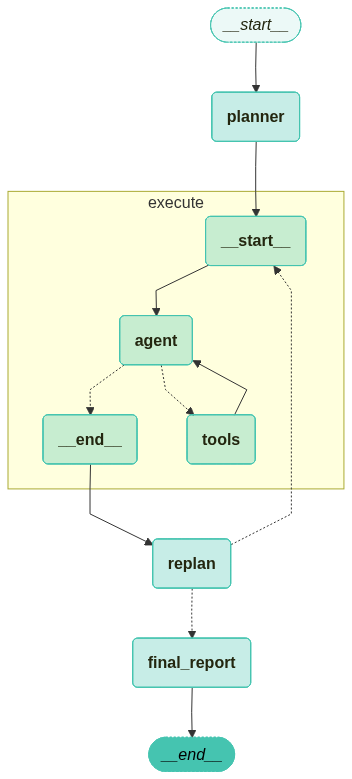

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

## 그래프 실행

In [15]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": """AI Agent 와 워크플로우의 차이에 대해서 설명하고, 각각의 장단점에 대해서 설명하세요"""
}

invoke_graph(app, inputs, config)


🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AI Agent와 워크플로우의 정의를 각각 설명한다.
AI Agent의 장점을 설명한다.
AI Agent의 단점을 설명한다.
워크플로우의 장점을 설명한다.
워크플로우의 단점을 설명한다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

AI Agent와 워크플로우의 정의를 각각 설명하겠습니다.

1. **AI Agent의 정의**:
   AI Agent는 인공지능 기술을 활용하여 특정 작업이나 문제를 해결하기 위해 설계된 소프트웨어 프로그램입니다. 이러한 에이전트는 주어진 환경에서 데이터를 수집하고, 분석하며, 그에 따라 행동을 결정하는 능력을 갖추고 있습니다. AI Agent는 자율적으로 작동할 수 있으며, 머신러닝, 자연어 처리, 컴퓨터 비전 등 다양한 AI 기술을 활용하여 복잡한 문제를 해결할 수 있습니다.

2. **워크플로우의 정의**:
   워크플로우는 특정 작업이나 프로세스를 완료하기 위해 필요한 일련의 단계나 절차를 정의한 것입니다. 이는 작업의 순서, 각 단계에서 수행해야 할 작업, 그리고 각 단계 간의 의존성을 명확히 하여 작업의 효율성을 높이고 오류를 줄이는 데 목적이 있습니다. 워크플로우는 비즈니스 프로세스 관리(BPM)에서 중요한 요소로, 조직 내에서 작업이 어떻게 진행되는지를 시각적으로 표현하고 관리할 수 있게 해줍니다.

🔄 Node: execute 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('AI Agent와 워크플로우의 정의를 각각 설명한다.', 'AI Agent와 워크플로우의 정의를 각각 설명하겠습니다.\n\n1. 

In [16]:
snapshot = app.get_state(config).values
print(snapshot["response"])

# AI Agent와 워크플로우의 차이 및 장단점 분석

## 서론

현대의 비즈니스 환경에서는 효율성과 생산성을 극대화하기 위해 다양한 기술과 시스템이 활용되고 있습니다. 그 중에서도 AI Agent와 워크플로우는 각각의 독특한 특성과 장단점을 가지고 있어, 조직의 목표와 필요에 따라 적절히 선택되고 사용됩니다. 본 보고서에서는 AI Agent와 워크플로우의 정의를 명확히 하고, 각각의 장단점을 분석하여 이들 간의 차이를 설명하고자 합니다.

## AI Agent의 정의 및 장단점

### 정의

AI Agent는 인공지능 기술을 활용하여 특정 작업이나 문제를 해결하기 위해 설계된 소프트웨어 프로그램입니다. 이러한 에이전트는 주어진 환경에서 데이터를 수집하고, 분석하며, 그에 따라 행동을 결정하는 능력을 갖추고 있습니다. AI Agent는 자율적으로 작동할 수 있으며, 머신러닝, 자연어 처리, 컴퓨터 비전 등 다양한 AI 기술을 활용하여 복잡한 문제를 해결할 수 있습니다.

### 장점

1. **효율성 향상**: 반복적이고 시간이 많이 소요되는 작업을 자동화하여 인간의 작업 효율성을 크게 향상시킵니다.
2. **24/7 가용성**: 휴식 없이 24시간 내내 작동할 수 있어 지속적인 지원을 제공합니다.
3. **데이터 분석 능력**: 대량의 데이터를 빠르게 분석하고 유의미한 인사이트를 도출할 수 있습니다.
4. **비용 절감**: 인건비를 절감할 수 있으며, 대규모 작업에서 비용 효율성을 높일 수 있습니다.
5. **개인화된 경험 제공**: 사용자 데이터를 분석하여 개인화된 경험을 제공합니다.

### 단점

1. **제한된 이해력**: 인간처럼 직관적이거나 창의적인 사고를 할 수 없습니다.
2. **데이터 의존성**: 학습된 데이터에 크게 의존하여, 데이터가 편향되거나 불완전할 경우 부정확한 판단을 할 수 있습니다.
3. **윤리적 문제**: 자동화된 시스템이 인간의 일자리를 대체하거나, 프라이버시 침해 문제를 일으킬 수 있습니다.
4. **비용**: 고급

In [17]:
from IPython.display import Markdown

Markdown(snapshot["response"])

# AI Agent와 워크플로우의 차이 및 장단점 분석

## 서론

현대의 비즈니스 환경에서는 효율성과 생산성을 극대화하기 위해 다양한 기술과 시스템이 활용되고 있습니다. 그 중에서도 AI Agent와 워크플로우는 각각의 독특한 특성과 장단점을 가지고 있어, 조직의 목표와 필요에 따라 적절히 선택되고 사용됩니다. 본 보고서에서는 AI Agent와 워크플로우의 정의를 명확히 하고, 각각의 장단점을 분석하여 이들 간의 차이를 설명하고자 합니다.

## AI Agent의 정의 및 장단점

### 정의

AI Agent는 인공지능 기술을 활용하여 특정 작업이나 문제를 해결하기 위해 설계된 소프트웨어 프로그램입니다. 이러한 에이전트는 주어진 환경에서 데이터를 수집하고, 분석하며, 그에 따라 행동을 결정하는 능력을 갖추고 있습니다. AI Agent는 자율적으로 작동할 수 있으며, 머신러닝, 자연어 처리, 컴퓨터 비전 등 다양한 AI 기술을 활용하여 복잡한 문제를 해결할 수 있습니다.

### 장점

1. **효율성 향상**: 반복적이고 시간이 많이 소요되는 작업을 자동화하여 인간의 작업 효율성을 크게 향상시킵니다.
2. **24/7 가용성**: 휴식 없이 24시간 내내 작동할 수 있어 지속적인 지원을 제공합니다.
3. **데이터 분석 능력**: 대량의 데이터를 빠르게 분석하고 유의미한 인사이트를 도출할 수 있습니다.
4. **비용 절감**: 인건비를 절감할 수 있으며, 대규모 작업에서 비용 효율성을 높일 수 있습니다.
5. **개인화된 경험 제공**: 사용자 데이터를 분석하여 개인화된 경험을 제공합니다.

### 단점

1. **제한된 이해력**: 인간처럼 직관적이거나 창의적인 사고를 할 수 없습니다.
2. **데이터 의존성**: 학습된 데이터에 크게 의존하여, 데이터가 편향되거나 불완전할 경우 부정확한 판단을 할 수 있습니다.
3. **윤리적 문제**: 자동화된 시스템이 인간의 일자리를 대체하거나, 프라이버시 침해 문제를 일으킬 수 있습니다.
4. **비용**: 고급 AI 시스템을 개발하고 유지하는 데 상당한 비용이 들 수 있습니다.
5. **보안 문제**: 해킹이나 악의적인 공격에 취약할 수 있습니다.

## 워크플로우의 정의 및 장단점

### 정의

워크플로우는 특정 작업이나 프로세스를 완료하기 위해 필요한 일련의 단계나 절차를 정의한 것입니다. 이는 작업의 순서, 각 단계에서 수행해야 할 작업, 그리고 각 단계 간의 의존성을 명확히 하여 작업의 효율성을 높이고 오류를 줄이는 데 목적이 있습니다. 워크플로우는 비즈니스 프로세스 관리(BPM)에서 중요한 요소로, 조직 내에서 작업이 어떻게 진행되는지를 시각적으로 표현하고 관리할 수 있게 해줍니다.

### 장점

1. **효율성 향상**: 작업의 순서를 체계적으로 정리하여 불필요한 단계를 줄이고, 작업의 효율성을 높입니다.
2. **일관성 유지**: 표준화된 절차를 통해 모든 작업이 동일한 방식으로 수행되도록 보장합니다.
3. **책임 명확화**: 각 단계에 대한 책임이 명확하게 정의되어 있습니다.
4. **의사소통 개선**: 팀 내에서의 의사소통을 개선합니다.
5. **문제 해결 용이**: 작업의 흐름을 시각화할 수 있어 문제 발생 시 원인을 쉽게 파악하고 해결할 수 있습니다.
6. **프로세스 최적화**: 병목 현상이나 비효율적인 단계를 식별하고 개선할 수 있습니다.

### 단점

1. **유연성 부족**: 사전에 정의된 절차와 규칙에 따라 작동하여 변화에 적응하기 어려울 수 있습니다.
2. **복잡성 증가**: 복잡한 워크플로우는 관리와 유지보수가 어려울 수 있습니다.
3. **의사결정 지연**: 여러 단계와 승인 절차로 인해 의사결정이 지연될 수 있습니다.
4. **비용 문제**: 초기 비용이 높을 수 있으며, 지속적인 유지보수와 업데이트에도 비용이 발생할 수 있습니다.
5. **기술적 제약**: 특정 소프트웨어나 플랫폼에 의존하는 경우 유연한 변경이 어려울 수 있습니다.

## 결론

AI Agent와 워크플로우는 각각의 장단점을 가지고 있으며, 조직의 목표와 필요에 따라 적절히 선택되어야 합니다. AI Agent는 자동화와 데이터 분석에 강점을 가지고 있으며, 워크플로우는 작업의 체계화와 일관성 유지에 유리합니다. 따라서, 이들 기술을 적절히 활용함으로써 조직의 효율성과 생산성을 극대화할 수 있을 것입니다.

In [18]:
print(snapshot["response"])

# AI Agent와 워크플로우의 차이 및 장단점 분석

## 서론

현대의 비즈니스 환경에서는 효율성과 생산성을 극대화하기 위해 다양한 기술과 시스템이 활용되고 있습니다. 그 중에서도 AI Agent와 워크플로우는 각각의 독특한 특성과 장단점을 가지고 있어, 조직의 목표와 필요에 따라 적절히 선택되고 사용됩니다. 본 보고서에서는 AI Agent와 워크플로우의 정의를 명확히 하고, 각각의 장단점을 분석하여 이들 간의 차이를 설명하고자 합니다.

## AI Agent의 정의 및 장단점

### 정의

AI Agent는 인공지능 기술을 활용하여 특정 작업이나 문제를 해결하기 위해 설계된 소프트웨어 프로그램입니다. 이러한 에이전트는 주어진 환경에서 데이터를 수집하고, 분석하며, 그에 따라 행동을 결정하는 능력을 갖추고 있습니다. AI Agent는 자율적으로 작동할 수 있으며, 머신러닝, 자연어 처리, 컴퓨터 비전 등 다양한 AI 기술을 활용하여 복잡한 문제를 해결할 수 있습니다.

### 장점

1. **효율성 향상**: 반복적이고 시간이 많이 소요되는 작업을 자동화하여 인간의 작업 효율성을 크게 향상시킵니다.
2. **24/7 가용성**: 휴식 없이 24시간 내내 작동할 수 있어 지속적인 지원을 제공합니다.
3. **데이터 분석 능력**: 대량의 데이터를 빠르게 분석하고 유의미한 인사이트를 도출할 수 있습니다.
4. **비용 절감**: 인건비를 절감할 수 있으며, 대규모 작업에서 비용 효율성을 높일 수 있습니다.
5. **개인화된 경험 제공**: 사용자 데이터를 분석하여 개인화된 경험을 제공합니다.

### 단점

1. **제한된 이해력**: 인간처럼 직관적이거나 창의적인 사고를 할 수 없습니다.
2. **데이터 의존성**: 학습된 데이터에 크게 의존하여, 데이터가 편향되거나 불완전할 경우 부정확한 판단을 할 수 있습니다.
3. **윤리적 문제**: 자동화된 시스템이 인간의 일자리를 대체하거나, 프라이버시 침해 문제를 일으킬 수 있습니다.
4. **비용**: 고급